# Dashboard of  experiments in post silicon for WL affinity (SKX) SPEC 17

In [29]:
%matplotlib inline

import os
from pca.analytics import *
from clustering.distortion import *
from clustering.clustering import *
from clustering.cluster_score import *

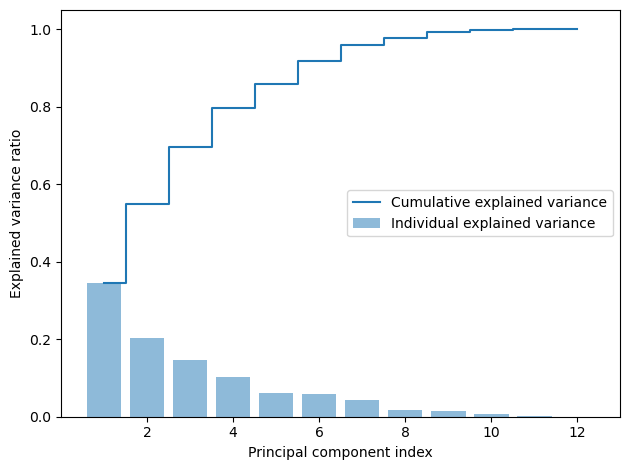

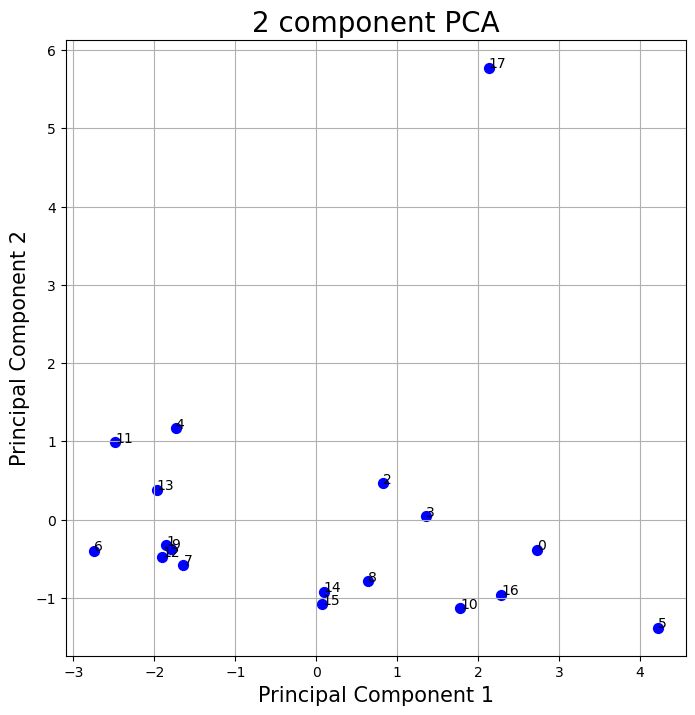

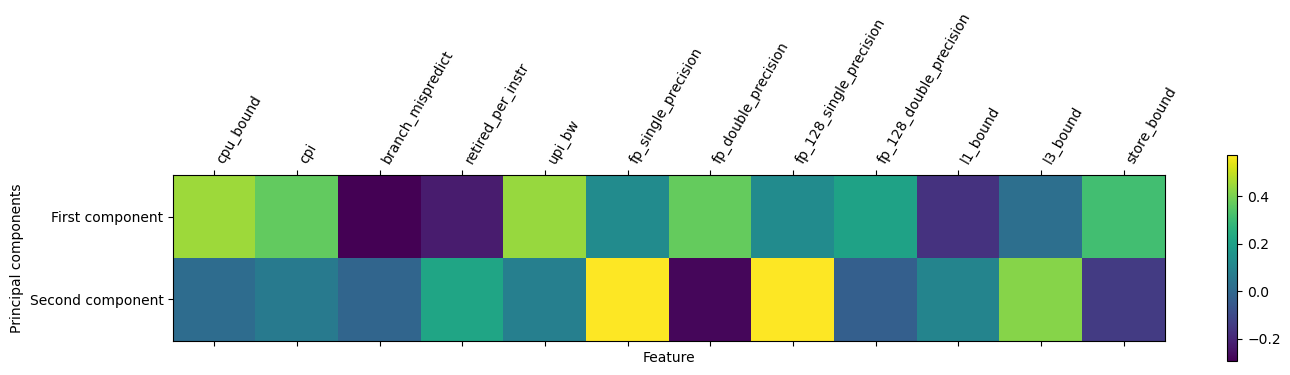

    principal component 1  principal component 2               test_name
0                2.725654              -0.384673       654.roms_s_result
1               -1.854081              -0.327589       625.x264_s_result
2                0.827578               0.465963       628.pop2_s_result
3                1.352992               0.042223  649.fotonik3d_s_result
4               -1.737025               1.163581    620.omnetpp_s_result
5                4.216169              -1.383042        619.lbm_s_result
6               -2.746178              -0.396442      641.leela_s_result
7               -1.641001              -0.578862  648.exchange2_s_result
8                0.639998              -0.791665       627.cam4_s_result
9               -1.793521              -0.374321         657.xz_s_result
10               1.780847              -1.132729  607.cactuBSSN_s_result
11              -2.481266               0.985290        605.mcf_s_result
12              -1.903340              -0.475727  6

In [30]:
%matplotlib inline

filename = 'post_silicon/summary.csv'
pca_df = None

if os.path.exists(filename):
    df = pd.read_csv(filename)

    features = list(df.columns)[1:]
    test_column = list(df.columns)[0]
    
    pca_df = get_PCA(df, features, test_column)
    print(pca_df)
else:
    print("Filename error")

# Plot characteristics of the worklaods

<AxesSubplot:ylabel='test_name'>

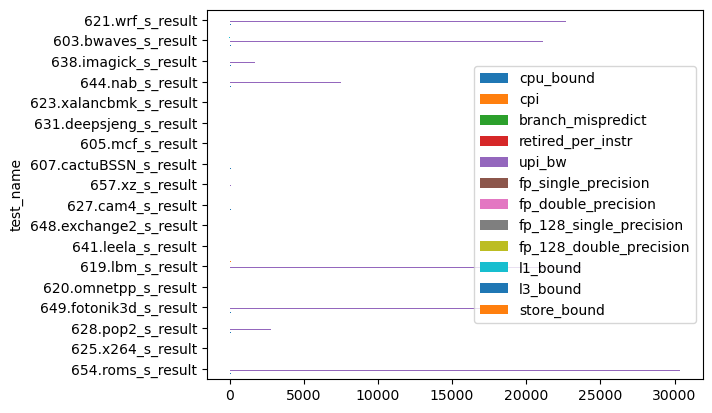

In [31]:
df.plot.barh(x="test_name")

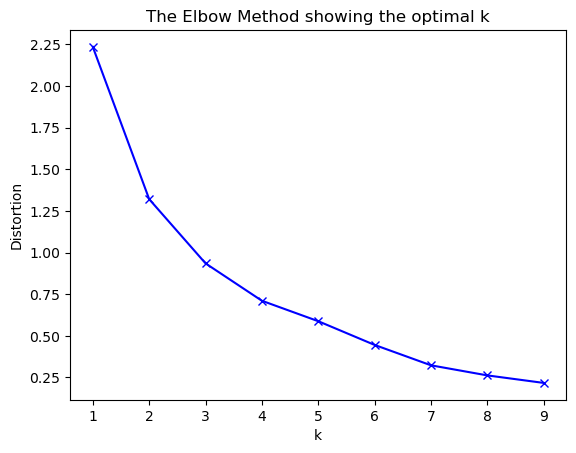

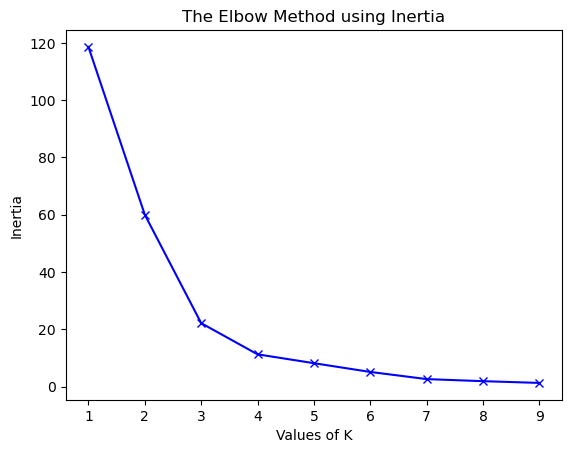

3


In [32]:
if os.path.exists("pca.csv"):    
    clusters = calculate_elbow(pd.read_csv("pca.csv"))


In [33]:
print(f'Optimal number of clusters = {clusters}')

Optimal number of clusters = 3


## Clasification based on optimal number of clusters

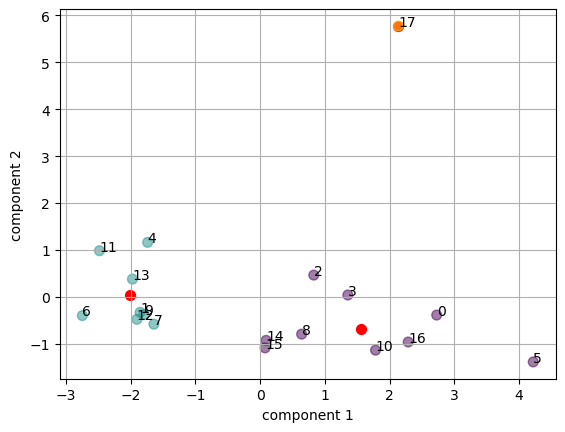

   PRED               test_name
0     0       654.roms_s_result
0     0       628.pop2_s_result
0     0  649.fotonik3d_s_result
0     0        619.lbm_s_result
0     0       627.cam4_s_result
0     0  607.cactuBSSN_s_result
0     0        644.nab_s_result
0     0    638.imagick_s_result
0     0     603.bwaves_s_result
1     1       625.x264_s_result
1     1    620.omnetpp_s_result
1     1      641.leela_s_result
1     1  648.exchange2_s_result
1     1         657.xz_s_result
1     1        605.mcf_s_result
1     1  631.deepsjeng_s_result
1     1  623.xalancbmk_s_result
2     2        621.wrf_s_result


In [34]:
df_result,kmeans = kmean_cluster("pca.csv",clusters)
print(df_result)

# Get the test cases closer to centroid

In [35]:
from sklearn.metrics import pairwise_distances_argmin_min
X = pd.read_csv("pca.csv", usecols = ['principal component 1','principal component 2'])
closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X)
pca_df = pd.read_csv("pca.csv")
df = pca_df.iloc[closest]
df

,Unnamed: 0,principal component 1,principal component 2,test_name
10,10,1.780847,-1.132729,607.cactuBSSN_s_result
13,13,-1.972098,0.380724,623.xalancbmk_s_result
17,17,2.132598,5.773578,621.wrf_s_result


,test_name,cpu_bound,cpi,branch_mispredict,retired_per_instr,upi_bw,fp_single_precision,fp_double_precision,fp_128_single_precision,fp_128_double_precision,l1_bound,l3_bound,store_bound
10,607.cactuBSSN_s_result,77.195533,2.674158,0.001628,0.000009,17910.240590,0.0000,0.417475,0.000000,6.753917e-03,0.346170,4.287639,7.516600
13,623.xalancbmk_s_result,0.951576,0.744193,0.003745,0.000043,11.145109,0.0000,0.000225,0.000000,0.000000e+00,14.538320,7.591558,0.168916
17,621.wrf_s_result,96.285554,5.901676,0.011980,0.000023,22660.246970,0.0954,0.051008,0.124271,2.270000e-07,12.462811,14.873351,6.566515


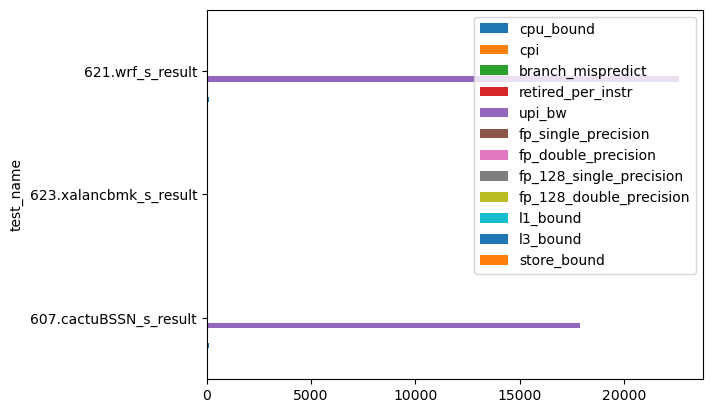

In [36]:
list_tests = df['test_name'].tolist()
df_global = pd.read_csv(filename)
df2 = df_global[df_global['test_name'].isin(list_tests)]
df2.plot.barh(x="test_name")
df2


## Clasification based on FP/INT clusters


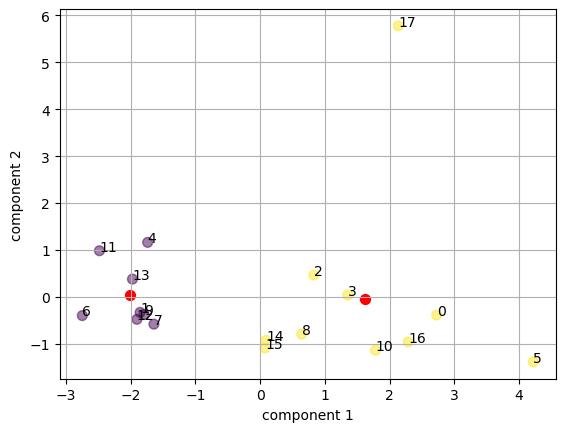

   PRED               test_name
0     0       625.x264_s_result
0     0    620.omnetpp_s_result
0     0      641.leela_s_result
0     0  648.exchange2_s_result
0     0         657.xz_s_result
0     0        605.mcf_s_result
0     0  631.deepsjeng_s_result
0     0  623.xalancbmk_s_result
1     1       654.roms_s_result
1     1       628.pop2_s_result
1     1  649.fotonik3d_s_result
1     1        619.lbm_s_result
1     1       627.cam4_s_result
1     1  607.cactuBSSN_s_result
1     1        644.nab_s_result
1     1    638.imagick_s_result
1     1     603.bwaves_s_result
1     1        621.wrf_s_result


In [37]:
df_result,kmeans = kmean_cluster("pca.csv",2)
print(df_result)

## Automatic label of clusters based cosine similarity to FP/INT


\begin{equation}
\cos ({\bf t},{\bf e})= {{\bf t} {\bf e} \over \|{\bf t}\| \|{\bf e}\|} = \frac{ \sum_{i=1}^{n}{{\bf t}_i{\bf e}_i} }{ \sqrt{\sum_{i=1}^{n}{({\bf t}_i)^2}} \sqrt{\sum_{i=1}^{n}{({\bf e}_i)^2}} }
\end{equation}

    REAL        test_name
0      0     603.bwaves_s
1      0  607.cactuBSSN_s
2      0        619.lbm_s
3      0       627.cam4_s
4      0       628.pop2_s
5      0  649.fotonik3d_s
6      0       654.roms_s
7      1        605.mcf_s
8      1    620.omnetpp_s
9      0        621.wrf_s
10     1  623.xalancbmk_s
11     1       625.x264_s
12     1  631.deepsjeng_s
13     0    638.imagick_s
14     1      641.leela_s
15     0        644.nab_s
16     1  648.exchange2_s
17     1         657.xz_s
    Unnamed: 0  PRED        test_name
0            0     0       625.x264_s
1            0     0    620.omnetpp_s
2            0     0      641.leela_s
3            0     0  648.exchange2_s
4            0     0         657.xz_s
5            0     0        605.mcf_s
6            0     0  631.deepsjeng_s
7            0     0  623.xalancbmk_s
8            1     1       654.roms_s
9            1     1       628.pop2_s
10           1     1  649.fotonik3d_s
11           1     1        619.lbm_s
12          

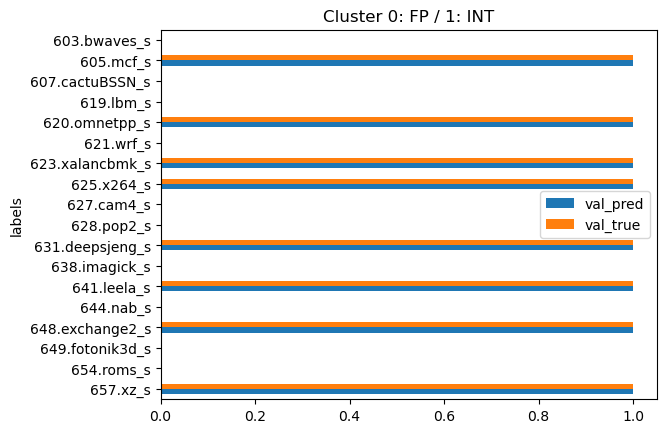

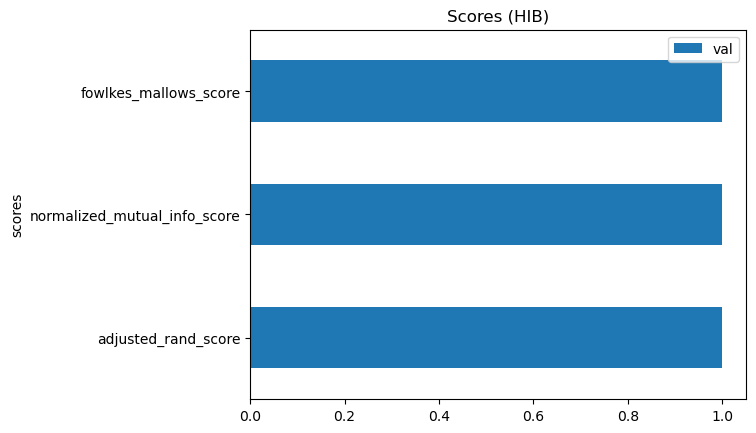

In [38]:
df = pd.read_csv("references/clusters_spec2017.csv")
print(df)
df_sorted = df.sort_values(by='REAL')
fp_tests = df_sorted[df_sorted['REAL'] == 0]
int_tests = df_sorted[df_sorted['REAL'] == 1]

df = pd.read_csv("clusters.csv")
df['test_name'] = df['test_name'].str.replace("_result","")
print(df)
df_sorted = df.sort_values(by='PRED')
A = df_sorted[df_sorted['PRED'] == 0]
B = df_sorted[df_sorted['PRED'] == 1]

C = normalize(A,B,fp_tests,int_tests)
C_sorted =  C.sort_values(by='test_name', ascending=False)

REAL = pd.read_csv("references/clusters_spec2017.csv")
REAL_sorted = REAL.sort_values(by='test_name', ascending=False)

labels_pred = C_sorted["PRED"].tolist()
labels_pred_ = [eval(i) for i in labels_pred]
labels_pred = labels_pred_

labels_true = REAL_sorted["REAL"].tolist()

df = pd.DataFrame({'labels':C_sorted['test_name'], 'val_pred':labels_pred, 'val_true':labels_true})
print()
print(df)

print()
print(df.loc[~(df['val_pred'] == df['val_true'])])


ax = df.plot.barh(x='labels', y=['val_pred','val_true'],  rot=0, title= "Cluster 0: FP / 1: INT")


scores_result = scores(labels_true,labels_pred)

df = pd.DataFrame({'scores':['adjusted_rand_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score'], 'val':scores_result[:-1]})
ax = df.plot.barh(x='scores', y='val', rot=0, title= "Scores (HIB)")